# Week 8, Lab #7

*March 6th, 2024*

So far, we've talked a lot about raster data, and a little bit about vector data. But it's rare that you'll ever exclusively be working with one or another on a project. In this lab, we'll combined vector and raster data in the context of (what I think is) a relatively interesting socioecological question.

**What is the relationship between household income levels and summertime land surface temperatures?**

To answer this question, we will be using household income data from [census blocks](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.html) and the [ECOSTRESS Thermal Radiometer](https://ecostress.jpl.nasa.gov/), which is on board the international space station.

We'll also be introducing a new library, `geopandas`, which is designed for working with vector data in Python, and is built on top of `pandas` and `shapely`.

The scene we're using from ECOSTRESS comes from August 24th, 2023. This was a relatively average summer day in Missoula - around 85 degrees Farenheit, or 28.9 degrees Celsius. The image was taken at 5:57 AM MST, and at that time it was around 11 degrees celsius, or 52 degrees Farenheit.

# Introduction to `GeoDataFrame`

Census blocks are identified using a unique identified called the `GEOID`. This is important to note so that we can use this as a grouping variable later. We can look at the fields in this geojson using the same methods as with any normal `pandas` dataset.

In [1]:
import geopandas as gpd
import rasterio as rio
import numpy as np

df = gpd.read_file("data/missoula_blocks_income.geojson")
df.head()

,OBJECTID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,B19001e12,B19001e13,B19001e14,B19001e15,B19001e16,B19001e17,lower_hholds,middle_hholds,upper_hholds,geometry
0,65,30,063,001304,2,300630013042,Block Group 2,G5030,S,2939945.0,...,62.0,91.0,108.0,111.0,17.0,180.0,3,247,416,"MULTIPOLYGON (((-114.07347 46.82318, -114.0715..."
1,67,30,063,001304,1,300630013041,Block Group 1,G5030,S,1880440.0,...,39.0,89.0,74.0,22.0,29.0,12.0,52,232,137,"MULTIPOLYGON (((-114.05049 46.82641, -114.0504..."
2,103,30,063,000901,4,300630009014,Block Group 4,G5030,S,7165419.0,...,59.0,125.0,71.0,60.0,0.0,0.0,115,420,131,"MULTIPOLYGON (((-114.10874 46.84160, -114.1085..."
3,104,30,063,000300,2,300630003002,Block Group 2,G5030,S,739280.0,...,109.0,85.0,0.0,0.0,18.0,0.0,408,335,18,"MULTIPOLYGON (((-114.00469 46.87530, -114.0040..."
4,188,30,063,000902,1,300630009021,Block Group 1,G5030,S,97032085.0,...,29.0,66.0,68.0,7.0,21.0,60.0,30,128,156,"MULTIPOLYGON (((-114.30506 46.83755, -114.3044..."


We can see that there are a whole bunch of field names that look like gibberish on their own - each column starting with "B" is the number of households within a certain income bracket (with the exception of `B19001e1`). I've gone ahead and created a few new columns that consolidate these into lower, middle, and upper classes.

 - `lower_hholds` is the *number of households* with 10,000 - 34999 dollars per year
 - `middle_hholds` is the *number of households* with 35000 - 99999 dollars per year
 - `upper_hholds` is the *number of households* with >= 100000 dollars per year
 - `B19001e1` is the total number of households within each census block

We can work with this `GeoDataFrame` pretty much all the same ways we work with a normal Pandas `DataFrame`. So what makes this a unique data type?

Well, for one, it has a CRS attribute:

In [2]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can also get the x and y coordinates of each polygon's points with the `gdf.get_coordinates()` method:

In [3]:
df.get_coordinates()

,x,y
0,-114.073467,46.823175
0,-114.071519,46.823771
0,-114.070520,46.823993
0,-114.069003,46.824331
0,-114.066429,46.824727
...,...,...
76,-114.042932,46.822127
76,-114.042903,46.822843
76,-114.042877,46.823591
76,-114.042912,46.824356


We can get do many other spatial-specific operations with ease, such as finding the minimum bounding circle around each polygon feature, getting the spatial bounds of each polygon, or getting the spatial bounds of the entire dataset. We also have access to the geometry of each feature through a special column called "geometry".

In [4]:
df.minimum_bounding_circle()

0     POLYGON ((-114.04020 46.81738, -114.04053 46.8...
1     POLYGON ((-114.02271 46.82217, -114.02302 46.8...
2     POLYGON ((-114.03915 46.84308, -114.03982 46.8...
3     POLYGON ((-113.99052 46.87402, -113.99066 46.8...
4     POLYGON ((-114.09641 46.84586, -114.09842 46.8...
                            ...                        
72    POLYGON ((-114.01804 46.83213, -114.01823 46.8...
73    POLYGON ((-114.02711 46.81449, -114.02728 46.8...
74    POLYGON ((-113.93083 46.87215, -113.93103 46.8...
75    POLYGON ((-114.01793 46.83698, -114.01814 46.8...
76    POLYGON ((-114.03287 46.82706, -114.03301 46.8...
Length: 77, dtype: geometry

In [5]:
df.bounds

,minx,miny,maxx,maxy
0,-114.073467,46.804016,-114.045264,46.832904
1,-114.050511,46.806155,-114.035536,46.838284
2,-114.108742,46.831511,-114.039479,46.855980
3,-114.004828,46.867215,-113.990577,46.879525
4,-114.305564,46.833958,-114.096791,46.931143
...,...,...,...,...
72,-114.037881,46.828870,-114.018235,46.834278
73,-114.042914,46.807262,-114.028895,46.820499
74,-113.951240,46.866953,-113.931329,46.877811
75,-114.039491,46.834216,-114.018245,46.839863


In [6]:
df.unary_union.bounds

(-114.6749420000732, 46.63157799982491, -113.47981699975469, 47.13812300027632)

In [7]:
df["geometry"]

0     MULTIPOLYGON (((-114.07347 46.82318, -114.0715...
1     MULTIPOLYGON (((-114.05049 46.82641, -114.0504...
2     MULTIPOLYGON (((-114.10874 46.84160, -114.1085...
3     MULTIPOLYGON (((-114.00469 46.87530, -114.0040...
4     MULTIPOLYGON (((-114.30506 46.83755, -114.3044...
                            ...                        
72    MULTIPOLYGON (((-114.03785 46.83150, -114.0378...
73    MULTIPOLYGON (((-114.04291 46.81980, -114.0407...
74    MULTIPOLYGON (((-113.95121 46.86706, -113.9511...
75    MULTIPOLYGON (((-114.03946 46.83662, -114.0394...
76    MULTIPOLYGON (((-114.04294 46.82522, -114.0429...
Name: geometry, Length: 77, dtype: geometry

As we can see, there are a number of "special" methods and attributes of `GeoDataFrames` that do not exist in just plain `DataFrames`. Similarly, `GeoDataFrames` can be mapped using their `.plot()` method, similar to how we use `pyplot.imshow(img)` for plotting raster data. For more information on the methods and attributes you can use and access with `GeoDataFrames`, check out the [documentation here](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html).

## Problem 7.1: Compute the proportion of households in each income class

**Compute the proportion of households within each income bracket for each census block. You should create a new column for each income bracket. Using the `.plot(column_name)` method on the geodataframe, map out the resulting proportions.**

**ANSWER 7.1**

In [8]:
# Create columns
df['ratio_low'] = df['lower_hholds'] / (df['lower_hholds'] + df['middle_hholds'] + df['upper_hholds'])
df['ratio_mid'] = df['middle_hholds'] / (df['lower_hholds'] + df['middle_hholds'] + df['upper_hholds'])
df['ratio_upp'] = df['upper_hholds'] / (df['lower_hholds'] + df['middle_hholds'] + df['upper_hholds'])

df.head()

,OBJECTID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,B19001e15,B19001e16,B19001e17,lower_hholds,middle_hholds,upper_hholds,geometry,ratio_low,ratio_mid,ratio_upp
0,65,30,063,001304,2,300630013042,Block Group 2,G5030,S,2939945.0,...,111.0,17.0,180.0,3,247,416,"MULTIPOLYGON (((-114.07347 46.82318, -114.0715...",0.004505,0.370871,0.624625
1,67,30,063,001304,1,300630013041,Block Group 1,G5030,S,1880440.0,...,22.0,29.0,12.0,52,232,137,"MULTIPOLYGON (((-114.05049 46.82641, -114.0504...",0.123515,0.551069,0.325416
2,103,30,063,000901,4,300630009014,Block Group 4,G5030,S,7165419.0,...,60.0,0.0,0.0,115,420,131,"MULTIPOLYGON (((-114.10874 46.84160, -114.1085...",0.172673,0.630631,0.196697
3,104,30,063,000300,2,300630003002,Block Group 2,G5030,S,739280.0,...,0.0,18.0,0.0,408,335,18,"MULTIPOLYGON (((-114.00469 46.87530, -114.0040...",0.536137,0.440210,0.023653
4,188,30,063,000902,1,300630009021,Block Group 1,G5030,S,97032085.0,...,7.0,21.0,60.0,30,128,156,"MULTIPOLYGON (((-114.30506 46.83755, -114.3044...",0.095541,0.407643,0.496815


<Axes: >

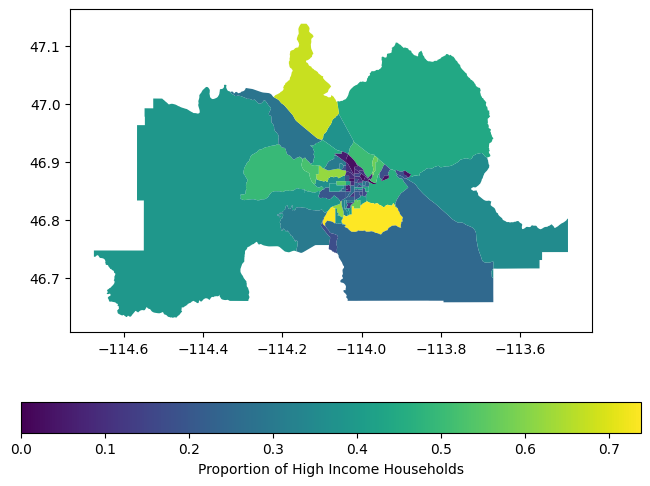

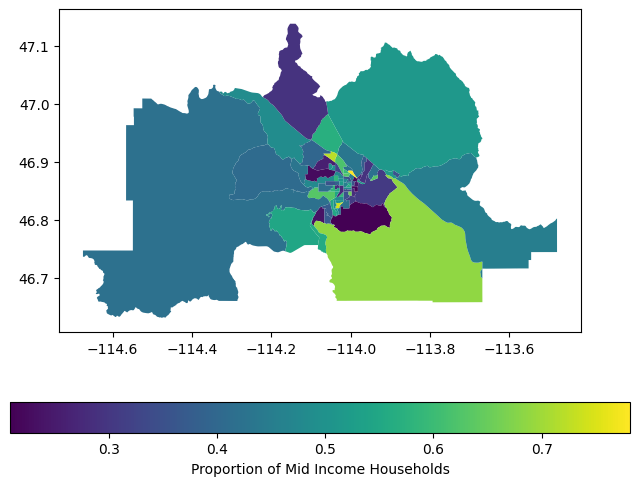

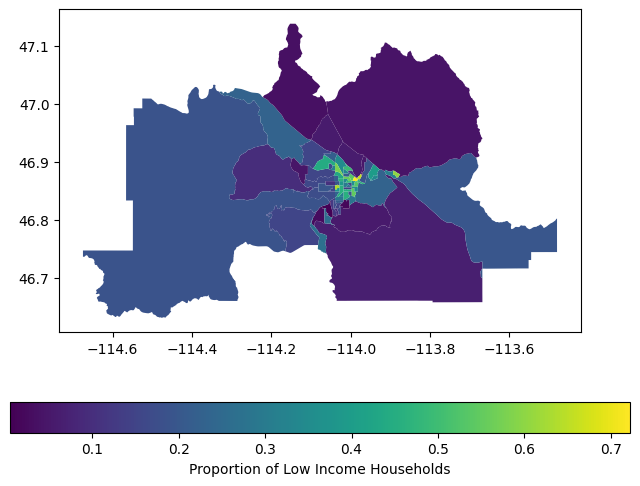

In [9]:
# Upper income plot
df.plot('ratio_upp', 
        figsize = (8, 6),
        legend = True,
        legend_kwds={"label": "Proportion of High Income Households", "orientation": "horizontal"}
       )

# Middle income plot
df.plot('ratio_mid', 
        figsize = (8, 6),
        legend = True,
        legend_kwds={"label": "Proportion of Mid Income Households", "orientation": "horizontal"}
       )

# Lower income plot
df.plot('ratio_low', 
        figsize = (8, 6),
        legend = True,
        legend_kwds={"label": "Proportion of Low Income Households", "orientation": "horizontal"}
       )

## Problem 7.2: Read in LST data

Let's read in our LST data from ECOSTRESS. This is a single-band image, but contains some zero values. We'll convert these to `np.nan` for display and analysis purposes. **Read this dataset in, convert it to `np.float32`, and convert any 0 values to `np.nan`. Plot the resulting raster.**

In [10]:
import matplotlib.pyplot as plt
ds = rio.open("data/ECO_L2_LSTE.002_LST_doy2023236125736_aid0001.tif")

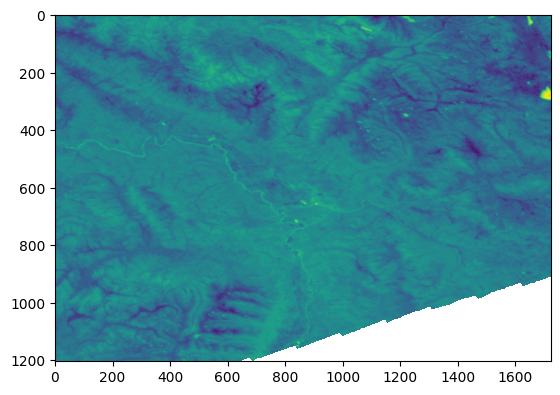

In [11]:
# Read file to array
arr = ds.read(1)

# Convert all values to np.float32
arr = arr.astype(np.float32)

# Covert 0 values to np.nan
arr[arr == 0] = np.nan

# Plot
plt.imshow(arr)

## Problem 7.3: Rasterize the census blocks and align them to the LST data

Now that we have our raster and vector data situated, we want to merge them somehow. In QGIS or ArcGIS, we might use the "zonal statistics" tools, but those tools can be limiting in terms of the functions available. Therefore, it's sometime useful to do these types of operations in Python. **Here, we'll first convert our vector data to a raster, and then use array operations to get the summary statistics that we want.**

`rasterio.features` has a very helpful function, `rasterize()`, that does most of this for us. We do, however, need to provide it with a list of geometries from our vector dataset, along with the values that we want in our raster that correspond to each geometry. [See the documentation for help on how to use this function](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html#rasterio.features.rasterize). `rasterize()` expects these data in a list of tuples, e.g. `[(POLYGON(...), 12.7), (POLYGON(...), 13.2)...]`. Recall that `geopandas` stores the geometry of each row in the `geometry` column.

**Write a function using the `def` keyword called `rasterize_and_align`. This function's arguments should be:** 
1. a `rasterio` dataset
2. a `geopandas` `GeoDataFrame`
3. a field name (as a string)

**For example, using the `ds` dataset and `df` `GeoDataFrame`, the function would be called like this:**

```python
rasterize_and_align(ds, df, "GEOID")
```

It should then rasterize each unique geometry in the vector dataset. The resulting rasterized array should have the same shape as the raster dataset. **The function should return an array.**

**We've written the first part of the function for you, already. Complete the rest of the function, adding the Python code necessary to call `features.rasterize()` and return an array.**

*Hint: You will need to check the field name, and if it is `GEOID`, you will need to convert the data to `np.int64`. You will also need to specify the `dtype` as an argument within `rasterize()` to handle this.*

In [12]:
from rasterio import features

def rasterize_and_align(raster, gdf, field):
    if field == "GEOID":
        gdf[field] = gdf[field].astype(np.int64)
    else:
        gdf[field] = gdf[field].astype(np.float32)
   
    out_transform = raster.transform
    out_shape = raster.shape
    # Get the geometries to be "burned" into our raster, along with the
    #    values (i.e., whatever "field" is)
    geoms = gdf[["geometry", field]].values.tolist()

    # Convert to raster using rasterize()
    if field == 'GEOID':
        converted = features.rasterize(geoms, out_shape = out_shape, transform = out_transform, dtype = np.int64)
    else:
        converted = features.rasterize(geoms, out_shape = out_shape, transform = out_transform, dtype = np.float32)
    
    
    return converted

## Problem 7.4: Rasterize the proportion of people in each income bracket and the GEOID, for each census block

Now, we want to use this function. **Using `rasterize_and_align()`, rasterize the `prop_*` fields you computed in 7.1, along with the `GEOID` fields.**

1. Flatten the resulting arrays (i.e., collapse the rows and columns into a single dimension, so that each row corresponds to a single pixel) using `array.flatten()`, and store the resulting data in some appreopriate data structure (e.g. `pandas DataFrame`, `dict`, `np.ndarray`).
2. Flatten and store your LST data in the same data structure (e.g., by creating a new column in the `pandas` `DataFrame`).
3. Rescale LST by using the equation $Celsius = DN * 0.02 - 273.15$, where $DN$ is the pixel value. This equation will convert ECOSTRESS LST to degrees Celsius. You should end up with numbers fairly close to the recorded air temperature (around 10-11 degrees Celsius).
4. Remove any data where the `GEOID` is equal to 0. This is the polygon corresponding to areas of nodata in the LST raster, which we don't want.
5. Print the number of observations in this dataset using either `shape` or `len`.

Since the LST data is aligned with all of your rasterized data, we will now be able to numerically analyze the relationships between the income level of the census blocks and LST. You should have exactly 831,897 observations for each variable (LST, proportion lower, proportion middle, proportion upper, GEOID).

In [13]:
# Rasterize the ratio_* fiels from 7.1 along with the GEOID field
ratio_upp = rasterize_and_align(ds, df, 'ratio_upp')
ratio_mid = rasterize_and_align(ds, df, 'ratio_mid')
ratio_low = rasterize_and_align(ds, df, 'ratio_low')
geoid = rasterize_and_align(ds, df, 'GEOID')

In [15]:
# Rescale LST using the equation C = pixel * 0.02 - 273.15
lst_c = arr * 0.02 - 273.15

In [16]:
import pandas as pd

# Initiiate an empty geodataframe
df = pd.DataFrame()

# Create columns of flattened rasters
df['ratio_upp'] = ratio_upp.flatten()
df['ratio_mid'] = ratio_mid.flatten()
df['ratio_low'] = ratio_low.flatten()
df['geoid'] = geoid.flatten()
df['temp'] = lst_c.flatten()

df.head()

,ratio_upp,ratio_mid,ratio_low,geoid,temp
0,0.0,0.0,0.0,0,8.429993
1,0.0,0.0,0.0,0,8.649994
2,0.0,0.0,0.0,0,10.029999
3,0.0,0.0,0.0,0,9.709991
4,0.0,0.0,0.0,0,9.769989


In [19]:
df = df[df['geoid'] != 0].copy() # Drop where geoid == 0
df1 = df.groupby('geoid').mean() # Group by GEOID where GEOID is the index
df1.shape

(77, 4)

In [20]:
df1.head()

,ratio_upp,ratio_mid,ratio_low,temp
geoid,,,,
300630001001,0.574539,0.373534,0.051926,9.721103
300630001002,0.504651,0.434884,0.060465,9.663030
300630001003,0.070064,0.273885,0.656051,10.195638
300630001004,0.000000,0.526846,0.473154,11.457396
300630001005,0.515915,0.291777,0.192308,10.093690


## Problem 7.5: Analyze the relationship between income levels and LST

Finally, at long last, let's look at the relationship between LST and income levels. To do this, we'll need to **get the mean LST for each `GEOID`, along with the proportion of households for each `GEOID`.** Depending on what data structure you used in the previous problem, you may be able to do this in one line, or you may need to write a `for` loop.

**Make three scatterplots with the proportion of households within each income bracket on the x-axes, and average census block LST on the y-axis.**

Text(0, 0.5, 'Surface Temperature (degC)')

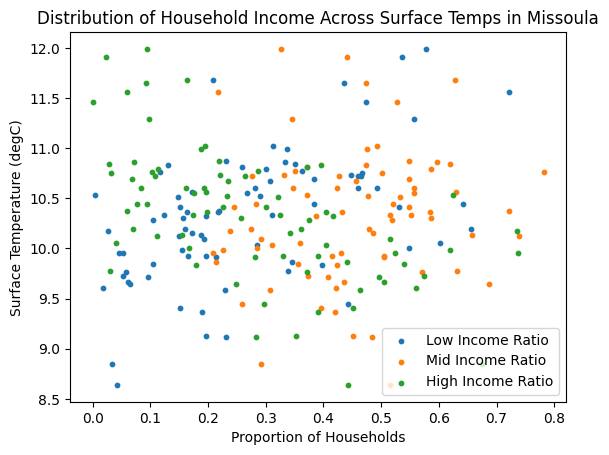

In [24]:
# Scatter plot income bracket proportions against mean census block surface temperature
import matplotlib.pyplot as plt

# Low
plt.scatter(df1['ratio_low'], df1['temp'], label = 'Low Income Ratio', s = 10)
# Mid
plt.scatter(df1['ratio_mid'], df1['temp'], label = 'Mid Income Ratio', s = 10)
# Upp
plt.scatter(df1['ratio_upp'], df1['temp'], label = 'High Income Ratio', s = 10)

plt.legend()
plt.title('Distribution of Household Income Across Surface Temps in Missoula')
plt.xlabel('Proportion of Households')
plt.ylabel('Surface Temperature (degC)')

---

## Extra Challenge: Extracting data to points

So far we've been working with polygons. Let's extract data for some points.

`airport_points.geojson` is just a few points near the airport - two of them are on asphalt, and two are on grass. This is denoted in the `cover` field. Loop through the points and extract the LST corresponding to each of these points. You can do this using the built-in `sample` function in `rasterio`, or you can go through and use the Affine transformation to get the row/column corresponding to each coordinate's lat/lon. Print the resulting dataframe.

In [25]:
airport = gpd.read_file("data/airport_points.geojson")

In [26]:
airport.head()

,cover,geometry
0,a,POINT (-114.08168 46.91861)
1,a,POINT (-114.08070 46.91757)
2,g,POINT (-114.08679 46.91283)
3,g,POINT (-114.08499 46.91121)


In [28]:
airport.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
airport.shape

(4, 2)

In [ ]:
import rasterio as rio



## Extra Challenge: Build a model explaining the relationship between income and LST

Let's say we want to go to city council with this ground-breaking analysis. Decision-makers want yes or no answers to questions, not fancy plots. Do poorer neighborhoods have less access to shade? To find out, we can build a simple linear model.

Using `scipy.stats.linregress()` (or any other linear regression implementation), solve for the slope, intercept, correlation coefficient, and pvalue of this relationship. Based on these models, do you think there is a relationship between income levels and LST?

In [102]:
from scipy.stats import linregress

## Extra Challenge: Make a map of average LST by census block